# Executive Summary:

The dataset, 'Stock_List_v2' is a composite of stock price and financial ratios data for public companies trading on the New York Stock Exchange or the NASDAQ. I created the dataset from scratch and sourced all data from an API for the financial data compiler service Financial Modeling Prep (https://site.financialmodelingprep.com/developer/docs/).

The goal of this analysis is to compare stock returns from a given company against the S&P 500 returns for that year. The S&P 500 is a popular stock market index that many investment professionals use as a performance benchmark. This model attempts to predict whether a stock beat the S&P 500 in a given year based key financial metrics from the prior year. For example, based on Apple's end of year financials in 2021, will Apple outperform the S&P 500 in 2022? Other key details include:
- Target variable:  'Beat_S&P?' - did the stock outperform the S&P for the given year?
- Time period:  data generally covers 2017-2022
- Independent variables:
    - Market Cap is the total value of a company's shares and is a good proxy for company size
    - Financial metrics are in "per share value" to standardize scale between small and large companies. These variables include typical measurement sure as revenue, profit, cashflow, ability to make interest payments, dividend payouts, etc. More information can be found here: https://site.financialmodelingprep.com/developer/

    #
## Note: This notebook was created for educational purposes and to improve data wrangling skills. It should not be used for financial decisions in any way
#
- Author: Will Merline

In [135]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split


from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


## Import data

In [136]:
##1. Import dataset from CVS file:
df = pd.read_csv('Stock_List_v2.csv')

In [137]:
# Exploratory data analysis:
df

,Unnamed: 0,Key,symbol,period,Year,Return,S&P500_return,Beat_S&P?,sector,MarketCap_Tier,...,PY_netIncomePerShare,PY_operatingCashFlowPerShare,PY_marketCap,PY_peRatio,PY_interestCoverage,PY_dividendYield,close,adjClose,PY_adjClose,date
0,0,ZYXI-2022,ZYXI,FY,2022,0.551722,-0.1817,Yes,Healthcare,small-cap,...,0.446355,0.181356,2.831626e+08,16.556313,235.431579,0.000004,13.910000,13.910000,8.964234,12/30/2022
1,1,ZYXI-2021,ZYXI,FY,2021,-0.259287,0.2875,No,Healthcare,small-cap,...,0.243559,0.021956,6.120128e+08,67.446863,539.421053,NaN,9.063600,8.964234,12.102167,12/31/2021
2,2,ZYXI-2020,ZYXI,FY,2020,0.710293,0.1837,Yes,Healthcare,small-cap,...,0.266010,0.176639,3.156315e+08,33.252370,2213.200000,0.007167,12.236400,12.102167,7.076080,12/31/2020
3,3,ZYXI-2019,ZYXI,FY,2019,1.676871,0.3122,Yes,Healthcare,micro-cap,...,0.267164,0.263137,1.251366e+08,13.100560,67.337662,NaN,7.154500,7.076080,2.643415,12/31/2019
4,4,ZYXI-2018,ZYXI,FY,2018,-0.050388,-0.0456,No,Healthcare,micro-cap,...,0.208218,0.233521,1.549919e+08,21.044386,6.168276,NaN,2.644294,2.643415,2.783678,12/31/2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23998,29612,A-2021,A,FY,2021,0.355096,0.2875,Yes,Healthcare,large-cap,...,2.326861,2.980583,3.612210e+10,50.239361,10.846154,0.006146,159.650000,158.397827,116.890472,12/31/2021
23999,29613,A-2020,A,FY,2020,0.397909,0.1837,Yes,Healthcare,large-cap,...,3.326087,3.170807,2.600794e+10,24.283790,12.716216,0.007921,118.490000,116.890472,83.618065,12/31/2020
24000,29614,A-2019,A,FY,2019,0.275396,0.3122,No,Healthcare,large-cap,...,0.969325,3.334356,2.358610e+10,74.639555,12.373333,0.008098,85.310000,83.618065,65.562431,12/31/2019
24001,29615,A-2018,A,FY,2018,0.016654,-0.0456,Yes,Healthcare,large-cap,...,2.054054,2.669670,2.305692e+10,33.708946,10.645570,0.007373,67.460000,65.562431,64.488472,12/31/2018


## Exploratory data analysis

In [138]:
# Exploratory data analysis
df.describe(include='all')

,Unnamed: 0,Key,symbol,period,Year,Return,S&P500_return,Beat_S&P?,sector,MarketCap_Tier,...,PY_netIncomePerShare,PY_operatingCashFlowPerShare,PY_marketCap,PY_peRatio,PY_interestCoverage,PY_dividendYield,close,adjClose,PY_adjClose,date
count,24003.000000,24003,24003,24003,24003.000000,24003.000000,24003.000000,24003,23791,24003,...,2.346900e+04,2.346900e+04,2.346900e+04,2.338700e+04,2.102100e+04,1.205800e+04,24003.000000,24003.000000,2.400300e+04,24003
unique,NaN,24003,5282,1,NaN,NaN,NaN,2,11,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
top,NaN,ZYXI-2022,ZYXI,FY,NaN,NaN,NaN,No,Healthcare,small-cap,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12/30/2022
freq,NaN,1,6,24003,NaN,NaN,NaN,14922,4511,7476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4721
mean,14793.302462,NaN,NaN,NaN,2019.713078,0.235559,0.122327,NaN,NaN,NaN,...,-4.141044e+03,-1.427736e+03,1.997801e+12,-9.914853e+03,-8.083778e+02,1.411350e-01,262.436605,255.574951,1.747417e+05,NaN
std,8547.515137,NaN,NaN,NaN,1.698691,8.739812,0.187456,NaN,NaN,NaN,...,3.762519e+05,1.516862e+05,2.742274e+14,1.120150e+06,9.435228e+04,3.882710e+00,10872.108301,10838.619236,2.615132e+07,NaN
min,0.000000,NaN,NaN,NaN,2017.000000,-6.214890,-0.181700,NaN,NaN,NaN,...,-5.214231e+07,-1.770870e+07,4.036230e+03,-1.553365e+08,-1.116428e+07,4.490000e-10,0.000450,-1.714073,-1.714073e+00,NaN
25%,7387.500000,NaN,NaN,NaN,2018.000000,-0.248496,-0.045600,NaN,NaN,NaN,...,-6.493405e-01,-6.863639e-02,2.404339e+08,-4.118954e+00,-9.714286e-01,1.250732e-02,9.100000,8.633155,9.850000e+00,NaN
50%,14791.000000,NaN,NaN,NaN,2020.000000,0.014194,0.183700,NaN,NaN,NaN,...,6.700447e-01,1.648886e+00,1.268577e+09,1.079855e+01,8.347184e-01,2.419059e-02,23.330000,21.660000,2.223000e+01,NaN
75%,22197.000000,NaN,NaN,NaN,2021.000000,0.279641,0.287500,NaN,NaN,NaN,...,2.575274e+00,4.596313e+00,6.289404e+09,2.309979e+01,6.233757e+00,4.374757e-02,51.865000,49.261999,4.794340e+01,NaN


In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24003 entries, 0 to 24002
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    24003 non-null  int64  
 1   Key                           24003 non-null  object 
 2   symbol                        24003 non-null  object 
 3   period                        24003 non-null  object 
 4   Year                          24003 non-null  int64  
 5   Return                        24003 non-null  float64
 6   S&P500_return                 24003 non-null  float64
 7   Beat_S&P?                     24003 non-null  object 
 8   sector                        23791 non-null  object 
 9   MarketCap_Tier                24003 non-null  object 
 10  PY_revenuePerShare            23469 non-null  float64
 11  PY_netIncomePerShare          23469 non-null  float64
 12  PY_operatingCashFlowPerShare  23469 non-null  float64
 13  P

In [140]:
print('Number of trading tickers (companies):', len(pd.unique(df['symbol'])))

Number of trading tickers (companies): 5282


In [141]:
# Show S&P returns for 2017-2022:
df_SP = df[['Year', 'S&P500_return']]
df_SP.head(6)

,Year,S&P500_return
0,2022,-0.1817
1,2021,0.2875
2,2020,0.1837
3,2019,0.3122
4,2018,-0.0456
5,2017,0.2170


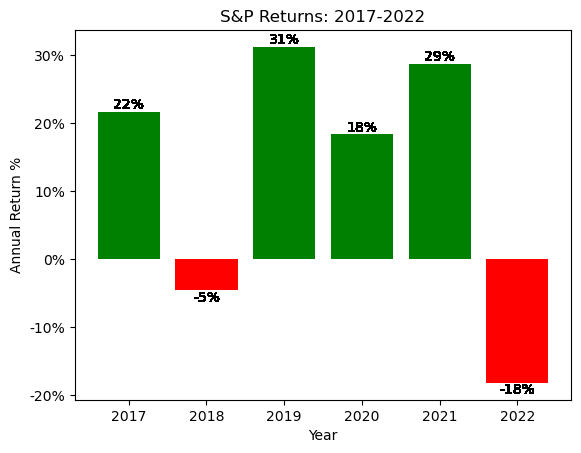

In [142]:
# S&P 500 returns by year:
from matplotlib.ticker import FuncFormatter

X = df_SP['Year']
Y = df_SP['S&P500_return']

# Set color as red for negative returns and green for positive returns:
colors = ['red' if val < 0 else 'green' for val in Y]

plt.bar(X, Y, color=colors)

# Add labels:
plt.xlabel("Year")
plt.ylabel("Annual Return %")
plt.title("S&P Returns: 2017-2022")


# Format y-axis as pecentages:
def perc_formatter(x, pos):
    return f'{x:.00%}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(perc_formatter))

# Add data labels to each bar for bar, label in zip(bars, y):
bars = plt.bar(X, Y, color=colors)
for bar, label in zip(bars, Y):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{label:.0%}',
             ha='center', va='bottom' if height > 0 else 'top', color='black')

# Display chart:
plt.show()

In [143]:
# Target (beat S&P) distribution:
SP_count = df['Beat_S&P?'].value_counts()
SP_perc = df['Beat_S&P?'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

print('Did company beat the S&P in a given year? \n', pd.concat([SP_count, SP_perc], axis=1, keys=['Count', '%']))


Did company beat the S&P in a given year? 
      Count      %
No   14922  62.2%
Yes   9081  37.8%


<AxesSubplot: ylabel='Beat_S&P?'>

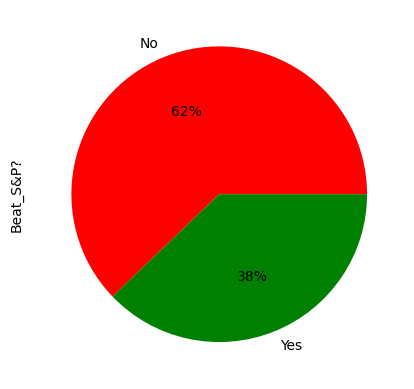

In [144]:
# # Target (beat S&P) distribution in a chart:
df['Beat_S&P?'].value_counts().plot.pie(colors=['r', 'g'], autopct='%1.0f%%')

In [145]:
# Sector distribution:
sector_count = df['sector'].value_counts()
sector_perc = df['sector'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
print('Sector distribution: \n', pd.concat([sector_count, sector_perc], axis=1, keys=['Count', '%']))
print(len(df['sector']))

Sector distribution: 
                         Count      %
Healthcare               4511  19.0%
Financial Services       4486  18.9%
Technology               3076  12.9%
Industrials              3000  12.6%
Consumer Cyclical        2382  10.0%
Real Estate              1512   6.4%
Communication Services   1106   4.6%
Energy                   1104   4.6%
Consumer Defensive       1025   4.3%
Basic Materials          1025   4.3%
Utilities                 564   2.4%
24003


<AxesSubplot: ylabel='sector'>

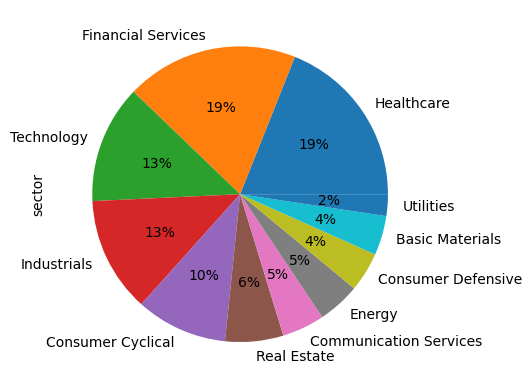

In [146]:
# Sector distribution pie chart:
df['sector'].value_counts().plot.pie(autopct='%1.0f%%')

In [147]:
# Market Cap distribution
MC_count = df['MarketCap_Tier'].value_counts()
MC_perc = df['MarketCap_Tier'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
print('Market Cap distribution: \n', pd.concat([MC_count, MC_perc], axis=1, keys=['Count', '%']))

Market Cap distribution: 
            Count      %
small-cap   7476  31.1%
micro-cap   5973  24.9%
mid-cap     5400  22.5%
large-cap   4620  19.2%
0            534   2.2%


<AxesSubplot: ylabel='MarketCap_Tier'>

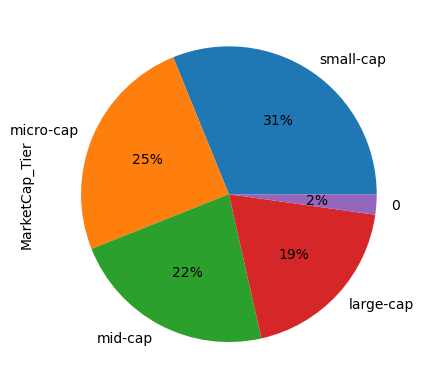

In [148]:
# Market Cap distribution pie chart:
df['MarketCap_Tier'].value_counts().plot.pie(autopct='%1.0f%%')

## Data pre-processing

In [149]:
# Pre-processing: remove rows with market cap = 0
df2 = df.copy()
df2 = df2.loc[df2['MarketCap_Tier'] !='0']

print(df2['MarketCap_Tier'].value_counts())

small-cap    7476
micro-cap    5973
mid-cap      5400
large-cap    4620
Name: MarketCap_Tier, dtype: int64


In [150]:
# Pre-processing: check for missing values:
df2.isna().sum()

Unnamed: 0                          0
Key                                 0
symbol                              0
period                              0
Year                                0
Return                              0
S&P500_return                       0
Beat_S&P?                           0
sector                             80
MarketCap_Tier                      0
PY_revenuePerShare                  0
PY_netIncomePerShare                0
PY_operatingCashFlowPerShare        0
PY_marketCap                        0
PY_peRatio                         82
PY_interestCoverage              2917
PY_dividendYield                11411
close                               0
adjClose                            0
PY_adjClose                         0
date                                0
dtype: int64

In [151]:
# There is no good way to impute the missing 'sector' values in this dataset. Only 270s rows are missing so I will remove NAs:
df2 = df2.dropna(subset=['sector'])
df2

,Unnamed: 0,Key,symbol,period,Year,Return,S&P500_return,Beat_S&P?,sector,MarketCap_Tier,...,PY_netIncomePerShare,PY_operatingCashFlowPerShare,PY_marketCap,PY_peRatio,PY_interestCoverage,PY_dividendYield,close,adjClose,PY_adjClose,date
0,0,ZYXI-2022,ZYXI,FY,2022,0.551722,-0.1817,Yes,Healthcare,small-cap,...,0.446355,0.181356,2.831626e+08,16.556313,235.431579,0.000004,13.910000,13.910000,8.964234,12/30/2022
1,1,ZYXI-2021,ZYXI,FY,2021,-0.259287,0.2875,No,Healthcare,small-cap,...,0.243559,0.021956,6.120128e+08,67.446863,539.421053,NaN,9.063600,8.964234,12.102167,12/31/2021
2,2,ZYXI-2020,ZYXI,FY,2020,0.710293,0.1837,Yes,Healthcare,small-cap,...,0.266010,0.176639,3.156315e+08,33.252370,2213.200000,0.007167,12.236400,12.102167,7.076080,12/31/2020
3,3,ZYXI-2019,ZYXI,FY,2019,1.676871,0.3122,Yes,Healthcare,micro-cap,...,0.267164,0.263137,1.251366e+08,13.100560,67.337662,NaN,7.154500,7.076080,2.643415,12/31/2019
4,4,ZYXI-2018,ZYXI,FY,2018,-0.050388,-0.0456,No,Healthcare,micro-cap,...,0.208218,0.233521,1.549919e+08,21.044386,6.168276,NaN,2.644294,2.643415,2.783678,12/31/2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23998,29612,A-2021,A,FY,2021,0.355096,0.2875,Yes,Healthcare,large-cap,...,2.326861,2.980583,3.612210e+10,50.239361,10.846154,0.006146,159.650000,158.397827,116.890472,12/31/2021
23999,29613,A-2020,A,FY,2020,0.397909,0.1837,Yes,Healthcare,large-cap,...,3.326087,3.170807,2.600794e+10,24.283790,12.716216,0.007921,118.490000,116.890472,83.618065,12/31/2020
24000,29614,A-2019,A,FY,2019,0.275396,0.3122,No,Healthcare,large-cap,...,0.969325,3.334356,2.358610e+10,74.639555,12.373333,0.008098,85.310000,83.618065,65.562431,12/31/2019
24001,29615,A-2018,A,FY,2018,0.016654,-0.0456,Yes,Healthcare,large-cap,...,2.054054,2.669670,2.305692e+10,33.708946,10.645570,0.007373,67.460000,65.562431,64.488472,12/31/2018


In [152]:
df2.isna().sum()

Unnamed: 0                          0
Key                                 0
symbol                              0
period                              0
Year                                0
Return                              0
S&P500_return                       0
Beat_S&P?                           0
sector                              0
MarketCap_Tier                      0
PY_revenuePerShare                  0
PY_netIncomePerShare                0
PY_operatingCashFlowPerShare        0
PY_marketCap                        0
PY_peRatio                         81
PY_interestCoverage              2913
PY_dividendYield                11380
close                               0
adjClose                            0
PY_adjClose                         0
date                                0
dtype: int64

It is OK for some companies to have missing values for some financial metrics. For example, an unprofitable company would have zero or potentially a negative operating cashflow per value and would likely not pay dividends.

Also, some companies may have not debt and therefore would have zero for Interest Coverage ratio. We will impute these values to equal zero. This approach is specific to this dataset and the context of the analysis

In [153]:
# Impute missing financial values to equal zero
imp_columns = ['PY_operatingCashFlowPerShare','PY_peRatio', 'PY_interestCoverage', 'PY_dividendYield']
imp_columns

imp_zero = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
df2[imp_columns] = imp_zero.fit_transform(df2[imp_columns])
df2

,Unnamed: 0,Key,symbol,period,Year,Return,S&P500_return,Beat_S&P?,sector,MarketCap_Tier,...,PY_netIncomePerShare,PY_operatingCashFlowPerShare,PY_marketCap,PY_peRatio,PY_interestCoverage,PY_dividendYield,close,adjClose,PY_adjClose,date
0,0,ZYXI-2022,ZYXI,FY,2022,0.551722,-0.1817,Yes,Healthcare,small-cap,...,0.446355,0.181356,2.831626e+08,16.556313,235.431579,0.000004,13.910000,13.910000,8.964234,12/30/2022
1,1,ZYXI-2021,ZYXI,FY,2021,-0.259287,0.2875,No,Healthcare,small-cap,...,0.243559,0.021956,6.120128e+08,67.446863,539.421053,0.000000,9.063600,8.964234,12.102167,12/31/2021
2,2,ZYXI-2020,ZYXI,FY,2020,0.710293,0.1837,Yes,Healthcare,small-cap,...,0.266010,0.176639,3.156315e+08,33.252370,2213.200000,0.007167,12.236400,12.102167,7.076080,12/31/2020
3,3,ZYXI-2019,ZYXI,FY,2019,1.676871,0.3122,Yes,Healthcare,micro-cap,...,0.267164,0.263137,1.251366e+08,13.100560,67.337662,0.000000,7.154500,7.076080,2.643415,12/31/2019
4,4,ZYXI-2018,ZYXI,FY,2018,-0.050388,-0.0456,No,Healthcare,micro-cap,...,0.208218,0.233521,1.549919e+08,21.044386,6.168276,0.000000,2.644294,2.643415,2.783678,12/31/2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23998,29612,A-2021,A,FY,2021,0.355096,0.2875,Yes,Healthcare,large-cap,...,2.326861,2.980583,3.612210e+10,50.239361,10.846154,0.006146,159.650000,158.397827,116.890472,12/31/2021
23999,29613,A-2020,A,FY,2020,0.397909,0.1837,Yes,Healthcare,large-cap,...,3.326087,3.170807,2.600794e+10,24.283790,12.716216,0.007921,118.490000,116.890472,83.618065,12/31/2020
24000,29614,A-2019,A,FY,2019,0.275396,0.3122,No,Healthcare,large-cap,...,0.969325,3.334356,2.358610e+10,74.639555,12.373333,0.008098,85.310000,83.618065,65.562431,12/31/2019
24001,29615,A-2018,A,FY,2018,0.016654,-0.0456,Yes,Healthcare,large-cap,...,2.054054,2.669670,2.305692e+10,33.708946,10.645570,0.007373,67.460000,65.562431,64.488472,12/31/2018


In [154]:
# Check values after imputation
df2.isna().sum()

Unnamed: 0                      0
Key                             0
symbol                          0
period                          0
Year                            0
Return                          0
S&P500_return                   0
Beat_S&P?                       0
sector                          0
MarketCap_Tier                  0
PY_revenuePerShare              0
PY_netIncomePerShare            0
PY_operatingCashFlowPerShare    0
PY_marketCap                    0
PY_peRatio                      0
PY_interestCoverage             0
PY_dividendYield                0
close                           0
adjClose                        0
PY_adjClose                     0
date                            0
dtype: int64

In [155]:
df2.head()

,Unnamed: 0,Key,symbol,period,Year,Return,S&P500_return,Beat_S&P?,sector,MarketCap_Tier,...,PY_netIncomePerShare,PY_operatingCashFlowPerShare,PY_marketCap,PY_peRatio,PY_interestCoverage,PY_dividendYield,close,adjClose,PY_adjClose,date
0,0,ZYXI-2022,ZYXI,FY,2022,0.551722,-0.1817,Yes,Healthcare,small-cap,...,0.446355,0.181356,283162618.8,16.556313,235.431579,0.000004,13.910000,13.910000,8.964234,12/30/2022
1,1,ZYXI-2021,ZYXI,FY,2021,-0.259287,0.2875,No,Healthcare,small-cap,...,0.243559,0.021956,612012832.7,67.446863,539.421053,0.000000,9.063600,8.964234,12.102167,12/31/2021
2,2,ZYXI-2020,ZYXI,FY,2020,0.710293,0.1837,Yes,Healthcare,small-cap,...,0.266010,0.176639,315631493.4,33.252370,2213.200000,0.007167,12.236400,12.102167,7.076080,12/31/2020
3,3,ZYXI-2019,ZYXI,FY,2019,1.676871,0.3122,Yes,Healthcare,micro-cap,...,0.267164,0.263137,125136550.0,13.100560,67.337662,0.000000,7.154500,7.076080,2.643415,12/31/2019
4,4,ZYXI-2018,ZYXI,FY,2018,-0.050388,-0.0456,No,Healthcare,micro-cap,...,0.208218,0.233521,154991906.5,21.044386,6.168276,0.000000,2.644294,2.643415,2.783678,12/31/2018


In [156]:
# Drop columns not needed in modeling:
df3 = df2.copy()
df3 = df3.drop(columns=['Unnamed: 0','Key', 'symbol', 'period', 'Year', 'Return', 'S&P500_return', 'PY_marketCap', 'close', 'adjClose',
                        'PY_adjClose', 'date'])

df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23389 entries, 0 to 24002
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Beat_S&P?                     23389 non-null  object 
 1   sector                        23389 non-null  object 
 2   MarketCap_Tier                23389 non-null  object 
 3   PY_revenuePerShare            23389 non-null  float64
 4   PY_netIncomePerShare          23389 non-null  float64
 5   PY_operatingCashFlowPerShare  23389 non-null  float64
 6   PY_peRatio                    23389 non-null  float64
 7   PY_interestCoverage           23389 non-null  float64
 8   PY_dividendYield              23389 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.8+ MB


In [157]:
df3

,Beat_S&P?,sector,MarketCap_Tier,PY_revenuePerShare,PY_netIncomePerShare,PY_operatingCashFlowPerShare,PY_peRatio,PY_interestCoverage,PY_dividendYield
0,Yes,Healthcare,small-cap,3.400606,0.446355,0.181356,16.556313,235.431579,0.000004
1,No,Healthcare,small-cap,2.150586,0.243559,0.021956,67.446863,539.421053,0.000000
2,Yes,Healthcare,small-cap,1.274336,0.266010,0.176639,33.252370,2213.200000,0.007167
3,Yes,Healthcare,micro-cap,0.892701,0.267164,0.263137,13.100560,67.337662,0.000000
4,No,Healthcare,micro-cap,0.662452,0.208218,0.233521,21.044386,6.168276,0.000000
...,...,...,...,...,...,...,...,...,...
23998,Yes,Healthcare,large-cap,17.278317,2.326861,2.980583,50.239361,10.846154,0.006146
23999,Yes,Healthcare,large-cap,16.034161,3.326087,3.170807,24.283790,12.716216,0.007921
24000,No,Healthcare,large-cap,15.073620,0.969325,3.334356,74.639555,12.373333,0.008098
24001,Yes,Healthcare,large-cap,13.429429,2.054054,2.669670,33.708946,10.645570,0.007373


## Data partition

In [158]:
# split Target, numerical, and categorical (need to one-hot encode) columns
cat_vars = ['sector', 'MarketCap_Tier']
num_vars = ['PY_revenuePerShare', 'PY_netIncomePerShare', 'PY_operatingCashFlowPerShare', 'PY_peRatio','PY_interestCoverage','PY_dividendYield']
target = 'Beat_S&P?'

In [159]:
# Encode target variable and partition data into train and test (80/20 split)

X = df3[cat_vars + num_vars]
y = df3[target].replace({'No': 0, 'Yes': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [160]:
# Check data partition
print('X:')
print(len(X))
print(len(X_train))
print(len(X_test))
print(len(X_train) + len(X_test))

print('\ny:')
print(len(y))
print(len(y_train))
print(len(y_test))
print(len(y_train) + len(y_test))

X:
23389
18711
4678
23389

y:
23389
18711
4678
23389


## Modeling pipeline

In [161]:
# Pipeline to one hot encode categorical variables (sector & MarketCap_Tier):
cat_tx = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', handle_unknown='error'))
])

In [162]:
preprocessor = ColumnTransformer(transformers=[
    ('categorical', cat_tx, cat_vars)
])

In [163]:
# Logistic Regression param grid:
LR_param_grid = {'max_iter': [30, 40]}
lr = LogisticRegression()
clf_lr = GridSearchCV(lr, LR_param_grid, scoring='roc_auc')

In [164]:
# Random Forest param grid:
RF_param_grid = {'max_depth':[8,9], 'min_samples_split': [3,4], 'min_samples_leaf': [2,3]}
rf = RandomForestClassifier()
clf_rf = GridSearchCV(rf, RF_param_grid, scoring='roc_auc')

In [165]:
# XGBoost param grid:
# XGB_param_grid = {'max_depth':[12, 14], 'scale_pos_weight' :[.10, .20]}
# xgb1 = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc')
# clf_xgb = GridSearchCV(xgb1, XGB_param_grid, scoring='roc_auc')

In [166]:
# Classifiers to use in pipeline:
classifier_list = [clf_lr,
                   clf_rf]
                   #clf_xgb]

In [167]:
# Run classifier models (Logistic Regression and Random Forest) and print accuracy and AUC scores:
i = 1
l = "Logistic Regression"
r = "Random Forest"

for clf, model_name in zip(classifier_list, [l, r]):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])
    model_pipeline = pipeline.fit(X_train, y_train)
    preds = model_pipeline.predict_proba(X_test)
    preds2 = model_pipeline.predict(X_test)

    auc= roc_auc_score(y_test, preds[:,1])
    print(f"AUC for {model_name}: {auc:.4f}")

AUC for Logistic Regression: 0.5351
AUC for Random Forest: 0.5428


In [168]:
print('LR params:', clf_lr.best_params_)
print('RF params:', clf_rf.best_params_)
#print('XGB params:', clf_xgb.best_params_)

LR params: {'max_iter': 30}
RF params: {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 3}


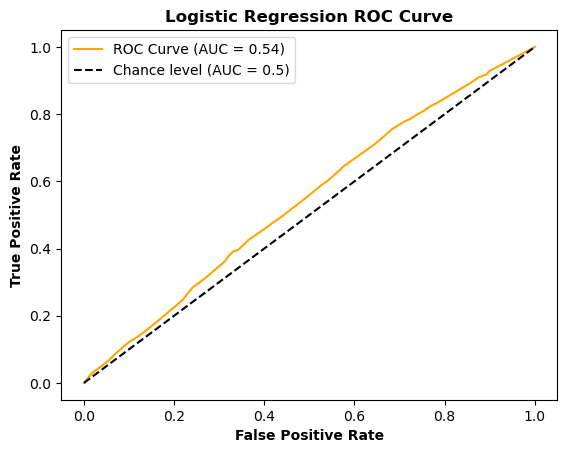

<Figure size 10000x5000 with 0 Axes>

In [169]:
# ROC curve, CF, and rejoin with DF for Random Forest
#Plot ROC curve
from scipy.ndimage import label
from matplotlib.pyplot import Figure
RocCurveDisplay.from_predictions(
    y_test, 
    preds[:,1],
    name='ROC Curve',
    color="orange",
)
plt.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")
plt.axis("auto")
plt.xlabel("False Positive Rate", fontweight = "bold")
plt.ylabel("True Positive Rate", fontweight = "bold")
plt.title("Logistic Regression ROC Curve", fontweight = "bold")
plt.legend()
plt.figure(figsize=(100,50))
plt.show()

In [170]:
# Define threshold lower than .5 to account for class imbalance:
t = 0.35

[[ 716 2189]
 [ 338 1435]]
False positive rate = 0.754
True positive rate = 0.809
Difference = 0.056


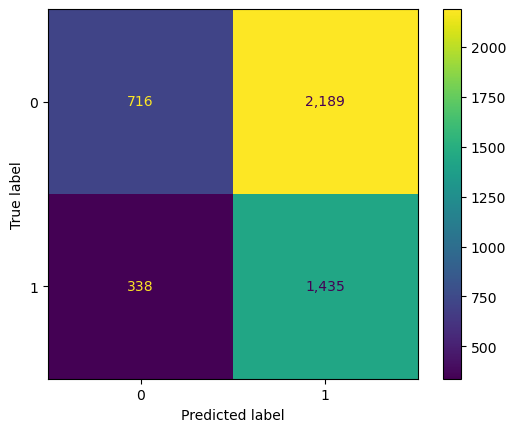

In [171]:
#13 Confusion matrix
cm = confusion_matrix(y_test, pd.Series([1 if x > t else 0 for x in preds[:,1]]))

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

TN = cm[0][0]
FN = cm[1][0]
FP = cm[0][1]
TP = cm[1][1]

FPR = FP/(FP+TN)
TPR = TP/(TP+FN)


print(cm)
cm_display.plot(values_format=',d', xticks_rotation='horizontal')

print('False positive rate =', FPR.round(3))
print('True positive rate =', TPR.round(3))
print('Difference =', (TPR - FPR).round(3))

## Model comparison:
- All three models have very similar AUC scores:
    - Logistic Regression AUC = 0.540
    - Random Forest AUC = 0.542
    - XGBoost classifier AUC = 0.544
- The XGBoost model consistently has the highest AUC by a very thin margin


Business pitch scenario: I have completed a proof-of-concept model, and I am now pitching the investment business to secure funding to build a more refined model.
- Investment professionals are always trying to beat the returns of the S&P 500

- During this proof-of-concept phase, we have built a model that successfully predicts better than random chance whether a stock will outperform the S&P500 benchmark

- With very limited funding/resources, we used publicly available financial metrics as inputs for the model. We believe that with additional funding to pay for more robust financial data from a reputable financial data compiler (Bloomberg, FactSet, etc.), we can continue to improve the model results

- Ultimately, this refined model can be used to create a portfolio of stocks with the goal of outperforming the S&P500 year after year. If successful, we can use the model to create multiple portfolios and market them as investment products to both institutional and retail investors

# Key takeaway: With access to better (professional) financial data, we can make a classifier model that makes more correct predictions

# Return Calculations

## Set-up dataframe

In [172]:
preds[:,1]

array([0.37749794, 0.32268717, 0.32268717, ..., 0.39301174, 0.42263594,
       0.37099314])

In [173]:
# Random Forest results:
results = pd.DataFrame(preds[:,1], columns = ['Random_Forest'])
results

,Random_Forest
0,0.377498
1,0.322687
2,0.322687
3,0.405272
4,0.370993
...,...
4673,0.487057
4674,0.388267
4675,0.393012
4676,0.422636


In [174]:
# Apply .35 threshold:
results['Classification_Result'] = np.where(results['Random_Forest'] > .35, 1,0)
results

,Random_Forest,Classification_Result
0,0.377498,1
1,0.322687,0
2,0.322687,0
3,0.405272,1
4,0.370993,1
...,...,...
4673,0.487057,1
4674,0.388267,1
4675,0.393012,1
4676,0.422636,1


In [175]:
# Add Yes/No column for interpretation:
results['Predicted_beat_S&P'] = np.where(results['Classification_Result'] == 1, 'Yes', 'No')
results

,Random_Forest,Classification_Result,Predicted_beat_S&P
0,0.377498,1,Yes
1,0.322687,0,No
2,0.322687,0,No
3,0.405272,1,Yes
4,0.370993,1,Yes
...,...,...,...
4673,0.487057,1,Yes
4674,0.388267,1,Yes
4675,0.393012,1,Yes
4676,0.422636,1,Yes


In [176]:
# Check results:
results['Predicted_beat_S&P'].value_counts()

Yes    3624
No     1054
Name: Predicted_beat_S&P, dtype: int64

In [177]:
# Get applicable columns in list:
results_list = ['symbol', 'Year', 'Return', 'S&P500_return']
results_list

['symbol', 'Year', 'Return', 'S&P500_return']

In [178]:
df2[results_list]

,symbol,Year,Return,S&P500_return
0,ZYXI,2022,0.551722,-0.1817
1,ZYXI,2021,-0.259287,0.2875
2,ZYXI,2020,0.710293,0.1837
3,ZYXI,2019,1.676871,0.3122
4,ZYXI,2018,-0.050388,-0.0456
...,...,...,...,...
23998,A,2021,0.355096,0.2875
23999,A,2020,0.397909,0.1837
24000,A,2019,0.275396,0.3122
24001,A,2018,0.016654,-0.0456


In [179]:
# Join X_test with df2 to get key variables such as stock return, ticker symbol, etc.:
X_data = pd.merge(X_test, df2[results_list], left_index = True, right_index=True)

In [180]:
X_data

,sector,MarketCap_Tier,PY_revenuePerShare,PY_netIncomePerShare,PY_operatingCashFlowPerShare,PY_peRatio,PY_interestCoverage,PY_dividendYield,symbol,Year,Return,S&P500_return
622,Financial Services,micro-cap,3.859768,0.944018,0.692431,36.545907,0.000000,0.009325,WMPN,2020,-0.007097,0.1837
22358,Healthcare,small-cap,0.084515,-1.052810,-0.909054,-6.449405,-17.803491,0.000000,ARDX,2021,-0.829985,0.2875
4591,Healthcare,small-cap,2.929809,-1.438155,-1.124140,-21.221640,-18.851469,0.000000,SILK,2022,0.240319,-0.1817
8854,Energy,small-cap,15.480220,0.100985,6.294172,229.737062,9.423111,0.023369,NOG,2022,0.545130,-0.1817
20190,Financial Services,mid-cap,7.774275,1.408723,1.523010,21.011945,0.000000,0.015171,CADE,2017,0.030203,0.2170
...,...,...,...,...,...,...,...,...,...,...,...,...
2552,Industrials,large-cap,7.600653,1.515512,1.616152,60.553776,233.868869,0.000000,TREX,2021,0.612876,0.2875
3144,Consumer Cyclical,large-cap,62.806411,12.346093,12.913122,17.592448,3.005367,0.000000,TCOM,2020,0.005665,0.1837
18257,Healthcare,mid-cap,18.775915,0.637195,2.854421,64.893780,2.433573,0.000000,CTLT,2019,0.805645,0.3122
14794,Consumer Cyclical,mid-cap,10.703364,4.340176,5.038396,18.140046,201.345522,0.028260,GHG,2020,0.218182,0.1837


In [181]:
# Combine with independent variables data:
X_data2 = X_data.reset_index()
df_results = pd.merge(results, X_data2, left_index=True, right_index=True)

In [182]:
df_results

,Random_Forest,Classification_Result,Predicted_beat_S&P,index,sector,MarketCap_Tier,PY_revenuePerShare,PY_netIncomePerShare,PY_operatingCashFlowPerShare,PY_peRatio,PY_interestCoverage,PY_dividendYield,symbol,Year,Return,S&P500_return
0,0.377498,1,Yes,622,Financial Services,micro-cap,3.859768,0.944018,0.692431,36.545907,0.000000,0.009325,WMPN,2020,-0.007097,0.1837
1,0.322687,0,No,22358,Healthcare,small-cap,0.084515,-1.052810,-0.909054,-6.449405,-17.803491,0.000000,ARDX,2021,-0.829985,0.2875
2,0.322687,0,No,4591,Healthcare,small-cap,2.929809,-1.438155,-1.124140,-21.221640,-18.851469,0.000000,SILK,2022,0.240319,-0.1817
3,0.405272,1,Yes,8854,Energy,small-cap,15.480220,0.100985,6.294172,229.737062,9.423111,0.023369,NOG,2022,0.545130,-0.1817
4,0.370993,1,Yes,20190,Financial Services,mid-cap,7.774275,1.408723,1.523010,21.011945,0.000000,0.015171,CADE,2017,0.030203,0.2170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4673,0.487057,1,Yes,2552,Industrials,large-cap,7.600653,1.515512,1.616152,60.553776,233.868869,0.000000,TREX,2021,0.612876,0.2875
4674,0.388267,1,Yes,3144,Consumer Cyclical,large-cap,62.806411,12.346093,12.913122,17.592448,3.005367,0.000000,TCOM,2020,0.005665,0.1837
4675,0.393012,1,Yes,18257,Healthcare,mid-cap,18.775915,0.637195,2.854421,64.893780,2.433573,0.000000,CTLT,2019,0.805645,0.3122
4676,0.422636,1,Yes,14794,Consumer Cyclical,mid-cap,10.703364,4.340176,5.038396,18.140046,201.345522,0.028260,GHG,2020,0.218182,0.1837


In [183]:
# Save the results dataframe to CSV file:
df_results.to_csv('Random_Forest_Results.csv')

## Calculate returns

In [184]:
df_returns = df_results.copy()

In [185]:
# Isolate positive predictions:
df_returns = df_returns.loc[df_returns['Predicted_beat_S&P'] == 'Yes']

In [186]:
df_returns

,Random_Forest,Classification_Result,Predicted_beat_S&P,index,sector,MarketCap_Tier,PY_revenuePerShare,PY_netIncomePerShare,PY_operatingCashFlowPerShare,PY_peRatio,PY_interestCoverage,PY_dividendYield,symbol,Year,Return,S&P500_return
0,0.377498,1,Yes,622,Financial Services,micro-cap,3.859768,0.944018,0.692431,36.545907,0.000000,0.009325,WMPN,2020,-0.007097,0.1837
3,0.405272,1,Yes,8854,Energy,small-cap,15.480220,0.100985,6.294172,229.737062,9.423111,0.023369,NOG,2022,0.545130,-0.1817
4,0.370993,1,Yes,20190,Financial Services,mid-cap,7.774275,1.408723,1.523010,21.011945,0.000000,0.015171,CADE,2017,0.030203,0.2170
5,0.405272,1,Yes,20409,Energy,small-cap,3.241945,-0.022366,1.498864,-50.969959,1.458791,0.000000,BTE,2020,-0.627586,0.1837
7,0.418682,1,Yes,17418,Technology,small-cap,1.610885,-2.111341,-1.586345,-14.047947,0.000000,0.000000,DMRC,2022,-0.531662,-0.1817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4673,0.487057,1,Yes,2552,Industrials,large-cap,7.600653,1.515512,1.616152,60.553776,233.868869,0.000000,TREX,2021,0.612876,0.2875
4674,0.388267,1,Yes,3144,Consumer Cyclical,large-cap,62.806411,12.346093,12.913122,17.592448,3.005367,0.000000,TCOM,2020,0.005665,0.1837
4675,0.393012,1,Yes,18257,Healthcare,mid-cap,18.775915,0.637195,2.854421,64.893780,2.433573,0.000000,CTLT,2019,0.805645,0.3122
4676,0.422636,1,Yes,14794,Consumer Cyclical,mid-cap,10.703364,4.340176,5.038396,18.140046,201.345522,0.028260,GHG,2020,0.218182,0.1837


In [187]:
df_returns['Year'].value_counts().sort_index()

2017    541
2018    555
2019    592
2020    589
2021    670
2022    677
Name: Year, dtype: int64

In [188]:
# Get rows counts for each year:
ct_2017 = sum(df_returns['Year'] == 2017)
ct_2018 = sum(df_returns['Year'] == 2018)
ct_2019 = sum(df_returns['Year'] == 2019)
ct_2020 = sum(df_returns['Year'] == 2020)
ct_2021 = sum(df_returns['Year'] == 2021)
ct_2022 = sum(df_returns['Year'] == 2022)

In [189]:
# Check counters:
print(ct_2017)
print(ct_2018)
print(ct_2019)
print(ct_2020)
print(ct_2021)
print(ct_2022)

541
555
592
589
670
677


In [190]:
# Hypothetical amount to invest each year = $100,000:
investment = 100000
investment

100000

In [191]:
# Calculate amount to invest in each stock per year:
    ## Total annual investment / number of stocks predicted to beat S&P that year
invest_2017 = (investment / ct_2017)
invest_2018 = (investment / ct_2018)
invest_2019 = (investment / ct_2019)
invest_2020 = (investment / ct_2020)
invest_2021 = (investment / ct_2021)
invest_2022 = (investment / ct_2022)

In [192]:
# Check investment amounts:
print(invest_2017)
print(invest_2018)
print(invest_2019)
print(invest_2020)
print(invest_2021)
print(invest_2022)

184.84288354898337
180.18018018018017
168.9189189189189
169.7792869269949
149.2537313432836
147.71048744460856


In [193]:
# Create principal investment column:
    # Year
conditions = [
    (df_returns['Year'] == 2017),
    (df_returns['Year'] == 2018),
    (df_returns['Year'] == 2019),
    (df_returns['Year'] == 2020),
    (df_returns['Year'] == 2021),
    (df_returns['Year'] == 2022)
]

# Investment each year:
values = [invest_2017, invest_2018, invest_2019, invest_2020, invest_2021, invest_2022]

# Create new column and assign values:
df_returns['Principal_Investment'] = np.select(conditions, values)

In [194]:
# Check dataframe:
df_returns

,Random_Forest,Classification_Result,Predicted_beat_S&P,index,sector,MarketCap_Tier,PY_revenuePerShare,PY_netIncomePerShare,PY_operatingCashFlowPerShare,PY_peRatio,PY_interestCoverage,PY_dividendYield,symbol,Year,Return,S&P500_return,Principal_Investment
0,0.377498,1,Yes,622,Financial Services,micro-cap,3.859768,0.944018,0.692431,36.545907,0.000000,0.009325,WMPN,2020,-0.007097,0.1837,169.779287
3,0.405272,1,Yes,8854,Energy,small-cap,15.480220,0.100985,6.294172,229.737062,9.423111,0.023369,NOG,2022,0.545130,-0.1817,147.710487
4,0.370993,1,Yes,20190,Financial Services,mid-cap,7.774275,1.408723,1.523010,21.011945,0.000000,0.015171,CADE,2017,0.030203,0.2170,184.842884
5,0.405272,1,Yes,20409,Energy,small-cap,3.241945,-0.022366,1.498864,-50.969959,1.458791,0.000000,BTE,2020,-0.627586,0.1837,169.779287
7,0.418682,1,Yes,17418,Technology,small-cap,1.610885,-2.111341,-1.586345,-14.047947,0.000000,0.000000,DMRC,2022,-0.531662,-0.1817,147.710487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4673,0.487057,1,Yes,2552,Industrials,large-cap,7.600653,1.515512,1.616152,60.553776,233.868869,0.000000,TREX,2021,0.612876,0.2875,149.253731
4674,0.388267,1,Yes,3144,Consumer Cyclical,large-cap,62.806411,12.346093,12.913122,17.592448,3.005367,0.000000,TCOM,2020,0.005665,0.1837,169.779287
4675,0.393012,1,Yes,18257,Healthcare,mid-cap,18.775915,0.637195,2.854421,64.893780,2.433573,0.000000,CTLT,2019,0.805645,0.3122,168.918919
4676,0.422636,1,Yes,14794,Consumer Cyclical,mid-cap,10.703364,4.340176,5.038396,18.140046,201.345522,0.028260,GHG,2020,0.218182,0.1837,169.779287


In [195]:
# Check total sum:
df_returns['Principal_Investment'].sum()

600000.0

In [196]:
# Check principal by year
df_returns['Principal_Investment'].value_counts()

147.710487    677
149.253731    670
168.918919    592
169.779287    589
180.180180    555
184.842884    541
Name: Principal_Investment, dtype: int64

In [197]:
# Calculate ending amount: invested principal * stock's return:
df_returns['Model_ending_amount'] = (df_returns['Principal_Investment'] * (1 + df_returns['Return']))

In [198]:
# Total dollar return from 2017-2022:
model_total = df_returns['Model_ending_amount'].sum()

In [199]:
# Sum returns by year:
return_2017 = df_returns.loc[df_returns['Year'] ==2017, 'Model_ending_amount'].sum()
return_2018 = df_returns.loc[df_returns['Year'] ==2018, 'Model_ending_amount'].sum()
return_2019 = df_returns.loc[df_returns['Year'] ==2019, 'Model_ending_amount'].sum()
return_2020 = df_returns.loc[df_returns['Year'] ==2020, 'Model_ending_amount'].sum()
return_2021 = df_returns.loc[df_returns['Year'] ==2021, 'Model_ending_amount'].sum()
return_2022 = df_returns.loc[df_returns['Year'] ==2022, 'Model_ending_amount'].sum()

model_returns = [return_2017, return_2018, return_2019, return_2020, return_2021, return_2022]

In [200]:
# Print return results by year:
print('2017: ' + '$' + format(return_2017, ',.0f'))
print('2018: ' + '$' + format(return_2018, ',.0f'))
print('2019: ' + '$' + format(return_2019, ',.0f'))
print('2020: ' + '$' + format(return_2020, ',.0f'))
print('2021: ' + '$' + format(return_2021, ',.0f'))
print('2022: ' + '$' + format(return_2022, ',.0f'))
print('---------------')
print('Total: '+ '$' + format(model_total, ',.0f'))

2017: $122,098
2018: $90,656
2019: $132,115
2020: $131,284
2021: $125,425
2022: $83,249
---------------
Total: $684,825


In [201]:
# Get S&P 500 returns by year:
df_returns['S&P500_return'].unique()
SP_2017 = df_returns.loc[df_returns['Year'] ==2017,'S&P500_return'].mean()
SP_2018 = df_returns.loc[df_returns['Year'] ==2018,'S&P500_return'].mean()
SP_2019 = df_returns.loc[df_returns['Year'] ==2019,'S&P500_return'].mean()
SP_2020 = df_returns.loc[df_returns['Year'] ==2020,'S&P500_return'].mean()
SP_2021 = df_returns.loc[df_returns['Year'] ==2021,'S&P500_return'].mean()
SP_2022 = df_returns.loc[df_returns['Year'] ==2022,'S&P500_return'].mean()

SP_returns = [SP_2017, SP_2018, SP_2019, SP_2020, SP_2021, SP_2022]

In [202]:
print('Model total 6-year return: '+' {:.2%}'.format(model_total_return_perc))

Model total 6-year return:  14.34%


In [203]:
# Print S&P 500 returns by year:
print('S&P 2017: '+' {:.2%}'.format(SP_2017))
print('S&P 2018: '+' {:.2%}'.format(SP_2018))
print('S&P 2019: '+' {:.2%}'.format(SP_2019))
print('S&P 2020: '+' {:.2%}'.format(SP_2020))
print('S&P 2021: '+' {:.2%}'.format(SP_2021))
print('S&P 2022: '+' {:.2%}'.format(SP_2022) )   

S&P 2017:  21.70%
S&P 2018:  -4.56%
S&P 2019:  31.22%
S&P 2020:  18.37%
S&P 2021:  28.75%
S&P 2022:  -18.17%


In [204]:
# Get years in a list:
year_list = [2017, 2018, 2019, 2020, 2021, 2022]

In [205]:
# Create dataframe with Model returns & S&P returns
df_summary = pd.DataFrame(list(zip(year_list, SP_returns, model_returns)),
                columns=['Year', 'S&P500_Return', 'Model_ending_dollar_amount'])

In [206]:
# Add yearly principal amount:
df_summary['Principal_investment'] = investment
df_summary

,Year,S&P500_Return,Model_ending_dollar_amount,Principal_investment
0,2017,0.2170,122097.847531,100000
1,2018,-0.0456,90655.776719,100000
2,2019,0.3122,132114.506286,100000
3,2020,0.1837,131283.584662,100000
4,2021,0.2875,125424.816885,100000
5,2022,-0.1817,83248.762201,100000


In [207]:
# Calculate S&P returns:
df_summary['S&P_ending_dollar_amount'] = df_summary['Principal_investment'] * (1+df_summary['S&P500_Return'])
df_summary

,Year,S&P500_Return,Model_ending_dollar_amount,Principal_investment,S&P_ending_dollar_amount
0,2017,0.2170,122097.847531,100000,121700.0
1,2018,-0.0456,90655.776719,100000,95440.0
2,2019,0.3122,132114.506286,100000,131220.0
3,2020,0.1837,131283.584662,100000,118370.0
4,2021,0.2875,125424.816885,100000,128750.0
5,2022,-0.1817,83248.762201,100000,81830.0


In [208]:
# Calculate average annual model return:
df_summary['Avg_annual_model_return'] = ((df_summary['Model_ending_dollar_amount'] / df_summary['Principal_investment']) - 1)
df_summary

,Year,S&P500_Return,Model_ending_dollar_amount,Principal_investment,S&P_ending_dollar_amount,Avg_annual_model_return
0,2017,0.2170,122097.847531,100000,121700.0,0.220978
1,2018,-0.0456,90655.776719,100000,95440.0,-0.093442
2,2019,0.3122,132114.506286,100000,131220.0,0.321145
3,2020,0.1837,131283.584662,100000,118370.0,0.312836
4,2021,0.2875,125424.816885,100000,128750.0,0.254248
5,2022,-0.1817,83248.762201,100000,81830.0,-0.167512


In [209]:
# Calculate dollar difference between Model returns and S&P returns:
df_summary['Dollar_difference'] = df_summary['Model_ending_dollar_amount'] - df_summary['S&P_ending_dollar_amount']
df_summary

,Year,S&P500_Return,Model_ending_dollar_amount,Principal_investment,S&P_ending_dollar_amount,Avg_annual_model_return,Dollar_difference
0,2017,0.2170,122097.847531,100000,121700.0,0.220978,397.847531
1,2018,-0.0456,90655.776719,100000,95440.0,-0.093442,-4784.223281
2,2019,0.3122,132114.506286,100000,131220.0,0.321145,894.506286
3,2020,0.1837,131283.584662,100000,118370.0,0.312836,12913.584662
4,2021,0.2875,125424.816885,100000,128750.0,0.254248,-3325.183115
5,2022,-0.1817,83248.762201,100000,81830.0,-0.167512,1418.762201


In [210]:
# Re-order columns:
df_summary_clean = df_summary.copy()
df_summary_clean = df_summary_clean.loc[:, ['Year', 'Avg_annual_model_return', 'S&P500_Return',  'Principal_investment', 
                                            'Model_ending_dollar_amount', 'S&P_ending_dollar_amount', 'Dollar_difference']]

In [211]:
df_summary_clean

,Year,Avg_annual_model_return,S&P500_Return,Principal_investment,Model_ending_dollar_amount,S&P_ending_dollar_amount,Dollar_difference
0,2017,0.220978,0.2170,100000,122097.847531,121700.0,397.847531
1,2018,-0.093442,-0.0456,100000,90655.776719,95440.0,-4784.223281
2,2019,0.321145,0.3122,100000,132114.506286,131220.0,894.506286
3,2020,0.312836,0.1837,100000,131283.584662,118370.0,12913.584662
4,2021,0.254248,0.2875,100000,125424.816885,128750.0,-3325.183115
5,2022,-0.167512,-0.1817,100000,83248.762201,81830.0,1418.762201


In [212]:
# Summary calculations:

principal_total_amt = df_summary_clean['Principal_investment'].sum()

model_total_amt = df_summary_clean['Model_ending_dollar_amount'].sum()

SP_total_amt = df_summary_clean['S&P_ending_dollar_amount'].sum()

num_years = df_summary_clean['Year'].count()

## View returns summary

In [213]:
# Return summary:
model_total_return_perc = (model_total_amt / principal_total_amt) - 1
SP_total_return_perc = (SP_total_amt / principal_total_amt) - 1

model_avg_annual_return_perc = model_total_return_perc / num_years
SP_avg_annual_return_perc = SP_total_return_perc / num_years

In [214]:
# Print return summary:
print('Model total 6-year return: '+' {:.2%}'.format(model_total_return_perc))
print('S&P 500 total 6-year return: '+' {:.2%}'.format(SP_total_return_perc))

print('\n')

print('Model average annual return: '+' {:.2%}'.format(model_avg_annual_return_perc))
print('S&P 500 average annual return:'+' {:.2%}'.format(SP_avg_annual_return_perc))

Model total 6-year return:  14.14%
S&P 500 total 6-year return:  12.88%


Model average annual return:  2.36%
S&P 500 average annual return: 2.15%


# Return metrics do no consider tax implications (capital gains), trading commissions, or other associated investment fees